In [1]:
from brian2 import *
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def calc_weight(M, alpha, mu, sigma):
    output = zeros((M,M))
    for i in np.arange(M):
        for j in np.arange(M):
            output[i,j] = exp(cos((2*pi*i/M) - (2*pi*j/M) - mu)/sigma**2)
    output = output * (alpha/np.max(output))
    output = 5.0 * fF * np.around(output/(5.0*fF))
    return output

In [3]:
def calc_weight_grid(M, alpha, mu, sigma):
    output = zeros((M))
    for i in np.arange(M):
        output[i] = exp(cos((2*pi*i/M) - mu)/sigma**2)
    output = output * (alpha/np.max(output))
    output = 5.0 * fF * np.around(output/(5.0*fF))
    return output

In [4]:
MODE = 'adaptive'
PARASITICS = True

In [5]:
# Define various equations

if MODE == 'adaptive':
    neuron_eq = '''
        dVm/dt = ((glm + gpar) / Cm) * (Vm_r - Vm)  : volt
        dVt/dt = ((glt + gpar) / Ct) * (Vt_r - Vt)  : volt
        
        # dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt
        # dVt/dt = (glt / Ct) * (Vt_r - Vt) : volt

        glm = flm * Cl                              : siemens
        glt = flt * Cl                              : siemens
        gpar = par_ctrl / par_leak_time * Cm : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
        Vt = Vt * (Vt > Vm) + Vt_r * (Vt <= Vm)
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
        Vt += (Cst/Ct) * (Vm_old - Vm_r)
    '''
else:
    neuron_eq = '''
        dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt

        glm = flm * Cl                    : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
    '''

# Synapse equation is the same for both modes!
syn_eq = '''
    Vsyn = (W/Cm)*(Em - Vm) : volt
    Em                      : volt
    W                       : farad
'''

In [6]:
# IFAT specific definitions
fF = 0.001 * pF
Vdd = 5 * volt
Cm = Ct = 440 * fF
Cl = 2 * fF

W_vals  = np.array([5, 10, 20, 40, 80]) * fF
Em_vals = np.array([0, 1/3, 2/3, 1]) * Vdd

par_ctrl = float(PARASITICS)
par_leak_time = 12.5 * ms

In [7]:
# Model parameters
Vm_r = 1 * volt
flm  = 0 * kHz
Csm  = W_vals[0]

Vt_r = 2* volt
flt  = 0 * MHz
Cst  = 0 * fF

M = 64

In [8]:
# Connectivity specifics
alpha = sum(W_vals)
mu1 = 0
mu2 = 2*pi/3
mu3 = pi
sigma = 36 * pi/180

In [199]:
# Preferred direction for cell
theta1 = 0
theta2 = theta1 + 2*pi/3
theta3 = theta2 + 2*pi/3
lam = 200 # meters
d1 = lam * np.asarray([cos(theta1),sin(theta1)])
d2 = lam * np.asarray([cos(theta2),sin(theta2)])
d3 = lam * np.asarray([cos(theta3),sin(theta3)])

In [200]:
def timedrandwalk(v=5, dt=0.001*second, time=10*second, size=5):
    nsteps = int(time/dt)
    rwpath = np.zeros([nsteps,2])
    rwvel  = np.zeros([nsteps,2])
    vel = v*np.random.random()
    theta=math.pi*np.random.random()
    dx = vel*math.cos(theta)
    dy = vel*math.sin(theta)
    rwpath[1,:] = [dx, dy]
    rwvel[1,:] = [dx, dy]
    for step in np.arange(2,nsteps):
        if (step % 10*ms/dt):
            rwpath[step,:] = rwpath[step-1,:]
        else:
            while (np.abs(rwpath[step,:])>=(size/2.)).any():
                vel = v*np.random.random()
                theta=math.pi*np.random.random()
                dx = vel*math.cos(theta)
                dy = vel*math.sin(theta)
                rwpath[step,:] = rwpath[step-1,:] + [dx, dy]
                rwvel[step,:] = [dx, dy]
                
    return rwpath, rwvel

In [201]:
def timedrandwalk2(v=5, dt=1*ms, time=10*second, size=5):
    nsteps = int(time/dt)
    rwpath = np.zeros([nsteps,2]) * size/2.
    rwvel  = np.zeros([nsteps,2])
    for step in np.arange(1,nsteps):
            while (rwpath[step,:]>=(size)).any() or (rwpath[step,:]<=0).any():
                theta=2*math.pi*np.random.random()
                dx = v*math.cos(theta)
                dy = v*math.sin(theta)
                rwpath[step,:] = rwpath[step-1,:] + [dx, dy]
                rwvel[step,:] = [dx, dy]
    return rwpath, rwvel

In [202]:
def raster_path(size=1, time=10*second, dt=1*ms):
    speed = 0.02 # meters/second
    length = round(time/dt)
    ss = np.linspace(-size,size,sqrt(length))

    path = np.zeros([length, 2])
    for idx,y in enumerate(ss):
        path[idx*ss.size:(idx+1)*ss.size,0] = -ss if idx%2 else ss
        path[idx*ss.size:(idx+1)*ss.size,1] = y

    vel = np.zeros_like(path)
    vel[:-1] = path[1:]-path[:-1]
    
    return path, vel

In [203]:
path, vel = timedrandwalk2(v=0.01,dt=1*ms,time=10*second,size=0.5)

In [204]:
#path, vel = raster_path(0.1,30*second,1*ms)

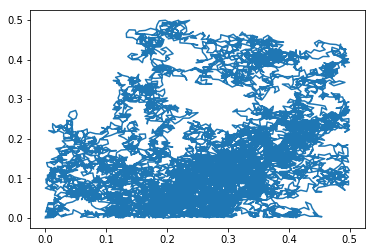

In [205]:
plot(path[:,0],path[:,1])

In [206]:
rundt =1*ms
runtime = 50000*ms
path, vel = timedrandwalk2(v=0.002,dt=rundt,time=runtime,size=0.1)
#path, vel = raster_path(0.1, 30*second, 1*ms)

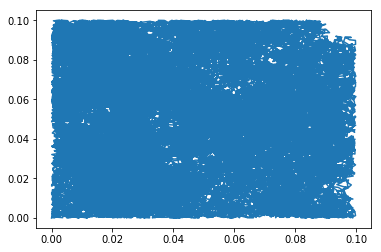

In [207]:
plot(path[:,0],path[:,1])

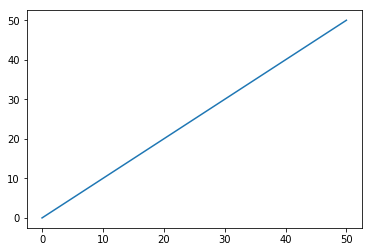

In [208]:
strt_vel = np.ones_like(vel) * 0.001

strt_path = cumsum(strt_vel, axis=0)

shape(strt_path)

plot(strt_path[:,0], strt_path[:,1])

veldot1 = TimedArray(np.dot(strt_vel,d1),dt=rundt)
veldot2 = TimedArray(np.dot(strt_vel,d2),dt=rundt)
veldot3 = TimedArray(np.dot(strt_vel,d3),dt=rundt)

In [209]:
# veldot1 = TimedArray(np.dot(vel,d1),dt=rundt)
# veldot2 = TimedArray(np.dot(vel,d2),dt=rundt)
# veldot3 = TimedArray(np.dot(vel,d3),dt=rundt)

In [210]:
Vt_r = 2*volt

In [211]:
start_scope()

G1 = NeuronGroup(2*M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
G1.Vt = Vt_r
G1.Vm = Vm_r
G1_exc = G1[:M]
G1_inh = G1[M:]

G1_e2i = Synapses(G1_exc, G1_inh, syn_eq, on_pre=presyn_eq)
G1_e2i.connect()
G1_e2i.Em = Em_vals[2]
G1_e2i.W = calc_weight(M,alpha,mu1,sigma).flatten()

G1_i2e = Synapses(G1_inh, G1_exc, syn_eq, on_pre=presyn_eq)
G1_i2e.connect()
G1_i2e.Em = Em_vals[0]
G1_i2e.W = calc_weight(M,alpha,mu2,sigma).flatten()

G1_i2i = Synapses(G1_inh, G1_inh, syn_eq, on_pre=presyn_eq)
G1_i2i.connect()
G1_i2i.Em = Em_vals[0]
G1_i2i.W = calc_weight(M,alpha,mu1,sigma).flatten()

P1_rates = '(3 + veldot1(t))*kHz'
P1 = PoissonGroup(M,rates=P1_rates)
P1_syn = Synapses(P1, G1_exc, syn_eq, on_pre=presyn_eq)
P1_syn.connect('j==i')
P1_syn.Em = Em_vals[2]
P1_syn.W = W_vals[1]# + W_vals[0]

G1e_sp = SpikeMonitor(G1_exc)
P1_rate = StateMonitor(P1, 'rates',record=True)

G2 = NeuronGroup(2*M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
G2.Vt = Vt_r
G2.Vm = Vm_r
G2_exc = G2[:M]
G2_inh = G2[M:]

G2_e2i = Synapses(G2_exc, G2_inh, syn_eq, on_pre=presyn_eq)
G2_e2i.connect()
G2_e2i.Em = Em_vals[2]
G2_e2i.W = calc_weight(M,alpha,mu1,sigma).flatten()

G2_i2e = Synapses(G2_inh, G2_exc, syn_eq, on_pre=presyn_eq)
G2_i2e.connect()
G2_i2e.Em = Em_vals[0]
G2_i2e.W = calc_weight(M,alpha,mu2,sigma).flatten()

G2_i2i = Synapses(G2_inh, G2_inh, syn_eq, on_pre=presyn_eq)
G2_i2i.connect()
G2_i2i.Em = Em_vals[0]
G2_i2i.W = calc_weight(M,alpha,mu1,sigma).flatten()

P2_rates = '(3 + veldot2(t))*kHz'
P2 = PoissonGroup(M,rates=P2_rates)
P2_syn = Synapses(P2, G2_exc, syn_eq, on_pre=presyn_eq)
P2_syn.connect('j==i')
P2_syn.Em = Em_vals[2]
P2_syn.W = W_vals[1]# + W_vals[0]

G2e_sp = SpikeMonitor(G2_exc)
P2_rate = StateMonitor(P2, 'rates',record=True)

G3 = NeuronGroup(2*M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
G3.Vt = Vt_r
G3.Vm = Vm_r
G3_exc = G3[:M]
G3_inh = G3[M:]

G3_e2i = Synapses(G3_exc, G3_inh, syn_eq, on_pre=presyn_eq)
G3_e2i.connect()
G3_e2i.Em = Em_vals[2]
G3_e2i.W = calc_weight(M,alpha,mu1,sigma).flatten()

G3_i2e = Synapses(G3_inh, G3_exc, syn_eq, on_pre=presyn_eq)
G3_i2e.connect()
G3_i2e.Em = Em_vals[0]
G3_i2e.W = calc_weight(M,alpha,mu2,sigma).flatten()

G3_i2i = Synapses(G3_inh, G3_inh, syn_eq, on_pre=presyn_eq)
G3_i2i.connect()
G3_i2i.Em = Em_vals[0]
G3_i2i.W = calc_weight(M,alpha,mu1,sigma).flatten()

P3_rates = '(3 + veldot3(t))*kHz'
P3 = PoissonGroup(M,rates=P3_rates)
P3_syn = Synapses(P3, G3_exc, syn_eq, on_pre=presyn_eq)
P3_syn.connect('j==i')
P3_syn.Em = Em_vals[2]
P3_syn.W = W_vals[1]# + W_vals[0]

G3e_sp = SpikeMonitor(G3_exc)
P3_rate = StateMonitor(P3, 'rates',record=True)

GRID = NeuronGroup(3, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
GRID.Vt = Vt_r
GRID.Vm = Vm_r
GRID0 = GRID[:1]
GRID1 = GRID[1:2]
GRID2 = GRID[2:]

G1_GRID0 = Synapses(G1_exc, GRID0, syn_eq, on_pre=presyn_eq)
G1_GRID0.connect()
G1_GRID0.Em = Em_vals[2]
G1_GRID0.W = calc_weight_grid(M, alpha/3, 0, 1*sigma)

G2_GRID0 = Synapses(G2_inh, GRID0, syn_eq, on_pre=presyn_eq)
G2_GRID0.connect()
G2_GRID0.Em = Em_vals[0]
G2_GRID0.W = calc_weight_grid(M, alpha, pi, 1*sigma)

G3_GRID0 = Synapses(G3_exc, GRID0, syn_eq, on_pre=presyn_eq)
G3_GRID0.connect()
G3_GRID0.Em = Em_vals[2]
G3_GRID0.W = calc_weight_grid(M, alpha/3, 0, 1*sigma)

GRID_sp = SpikeMonitor(GRID)
GRID_v = StateMonitor(GRID, 'Vm', record=True)
GRID0_rate = PopulationRateMonitor(GRID0)

store()

In [212]:
restore()
BrianLogger.suppress_hierarchy('brian2.codegen.generators.base')
run(runtime,report='text')

Starting simulation at t=0. s for a duration of 50. s
3.866 (7%) simulated in 10s, estimated 1m 59s remaining.
7.7049 (15%) simulated in 20s, estimated 1m 50s remaining.
11.5806 (23%) simulated in 30s, estimated 1m 40s remaining.
15.392900000000001 (30%) simulated in 40s, estimated 1m 30s remaining.
19.2571 (38%) simulated in 50s, estimated 1m 20s remaining.
23.1048 (46%) simulated in 1m 0s, estimated 1m 10s remaining.
26.9251 (53%) simulated in 1m 10s, estimated 1m 0s remaining.
30.770000000000003 (61%) simulated in 1m 20s, estimated 50s remaining.
34.6546 (69%) simulated in 1m 30s, estimated 40s remaining.
38.5431 (77%) simulated in 1m 40s, estimated 30s remaining.
42.431200000000004 (84%) simulated in 1m 50s, estimated 20s remaining.
46.3151 (92%) simulated in 2m 0s, estimated 10s remaining.
50.0 (100%) simulated in 2m 9s


(4, 5)

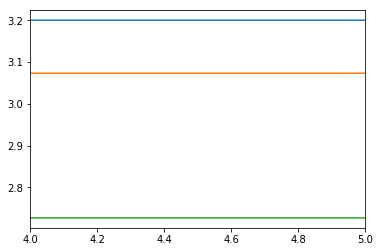

In [213]:
plot(P1_rate.t/second, P1_rate.rates[0]/kHz,
     P2_rate.t/second, P2_rate.rates[0]/kHz,
     P3_rate.t/second, P3_rate.rates[0]/kHz)
xlim([4,5])

(32, 36)

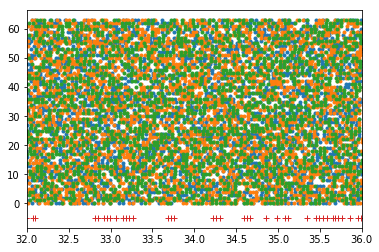

In [222]:
plot(G1e_sp.t/second, G1e_sp.i,'.C0',
     G2e_sp.t/second, G2e_sp.i,'.C1',
     G3e_sp.t/second, G3e_sp.i,'.C2',
     GRID_sp.t/second, GRID_sp.i-5,'+C3')
xlim([32,36])
#xlim([0.8,1])

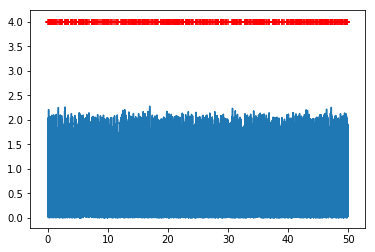

In [215]:
plot(GRID_v.t/second, GRID_v.Vm[0]/volt)
scatter(GRID_sp.t[GRID_sp.i==0]/second,4*ones(len(GRID_sp.t[GRID_sp.i==0])),marker='+',color='r')
#xlim([3.4,4.4])

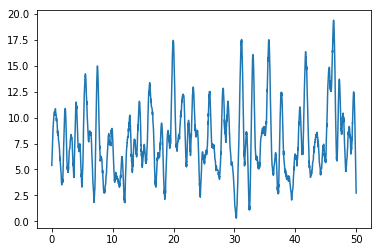

In [223]:
plot(GRID0_rate.t/second, GRID0_rate.smooth_rate(width=200*ms))

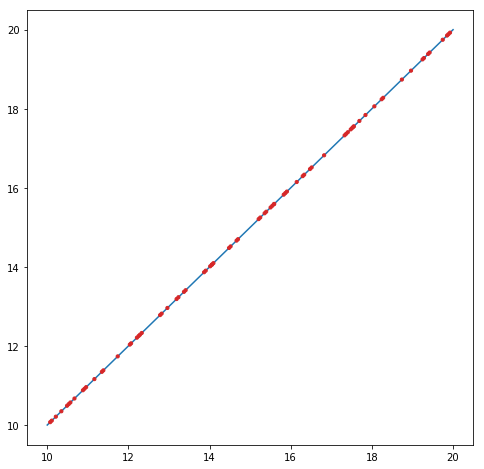

In [217]:
times = np.zeros_like(strt_path[:,0])
times[np.array(GRID_sp.t/(rundt),dtype=int)] = 1
st=10000
en=20000#len(path)
figure(figsize=(8,8))
plot(strt_path[st:en,0],strt_path[st:en,1], zorder=1);
scatter(strt_path[st:en,0],strt_path[st:en,1], s=times*10, color='C3', zorder=2)
# plot(path[st:en,0],path[st:en,1],zorder=1)
# scatter(path[st:en,0], path[st:en,1], s=times*20, color='C3', zorder=2)

# hoping for grid like pattern

In [ ]:
spike_times = []
nruns = 10
size = int(runtime/defaultclock.dt)
#avg_rates100 = np.zeros((int(runtime/defaultclock.dt),nruns))
#avg_rates250 = np.zeros((100000,nruns))
grid_rates = []

for idx in range(nruns):
    start_scope()

    G1 = NeuronGroup(2*M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
    G1.Vt = Vt_r
    G1.Vm = Vm_r
    G1_exc = G1[:M]
    G1_inh = G1[M:]

    G1_e2i = Synapses(G1_exc, G1_inh, syn_eq, on_pre=presyn_eq)
    G1_e2i.connect()
    G1_e2i.Em = Em_vals[3]
    G1_e2i.W = calc_weight(M,alpha,mu1,sigma).flatten()

    G1_i2e = Synapses(G1_inh, G1_exc, syn_eq, on_pre=presyn_eq)
    G1_i2e.connect()
    G1_i2e.Em = Em_vals[0]
    G1_i2e.W = calc_weight(M,alpha,mu2,sigma).flatten()

    G1_i2i = Synapses(G1_inh, G1_inh, syn_eq, on_pre=presyn_eq)
    G1_i2i.connect()
    G1_i2i.Em = Em_vals[0]
    G1_i2i.W = calc_weight(M,alpha,mu1,sigma).flatten()

    P1_rates = '(3 + veldot1(t))*kHz'
    P1 = PoissonGroup(M,rates=P1_rates)
    P1_syn = Synapses(P1, G1_exc, syn_eq, on_pre=presyn_eq)
    P1_syn.connect('j==i')
    P1_syn.Em = Em_vals[3]
    P1_syn.W = W_vals[2] + W_vals[0]

    #G1e_sp = SpikeMonitor(G1_exc)
    #P1_rate = StateMonitor(P1, 'rates',record=True)

    G2 = NeuronGroup(2*M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
    G2.Vt = Vt_r
    G2.Vm = Vm_r
    G2_exc = G2[:M]
    G2_inh = G2[M:]

    G2_e2i = Synapses(G2_exc, G2_inh, syn_eq, on_pre=presyn_eq)
    G2_e2i.connect()
    G2_e2i.Em = Em_vals[3]
    G2_e2i.W = calc_weight(M,alpha,mu1,sigma).flatten()

    G2_i2e = Synapses(G2_inh, G2_exc, syn_eq, on_pre=presyn_eq)
    G2_i2e.connect()
    G2_i2e.Em = Em_vals[0]
    G2_i2e.W = calc_weight(M,alpha,mu2,sigma).flatten()

    G2_i2i = Synapses(G2_inh, G2_inh, syn_eq, on_pre=presyn_eq)
    G2_i2i.connect()
    G2_i2i.Em = Em_vals[0]
    G2_i2i.W = calc_weight(M,alpha,mu1,sigma).flatten()

    P2_rates = '(3 + veldot2(t))*kHz'
    P2 = PoissonGroup(M,rates=P2_rates)
    P2_syn = Synapses(P2, G2_exc, syn_eq, on_pre=presyn_eq)
    P2_syn.connect('j==i')
    P2_syn.Em = Em_vals[3]
    P2_syn.W = W_vals[2] + W_vals[0]

    #G2e_sp = SpikeMonitor(G2_exc)
    #P2_rate = StateMonitor(P2, 'rates',record=True)

    G3 = NeuronGroup(2*M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
    G3.Vt = Vt_r
    G3.Vm = Vm_r
    G3_exc = G3[:M]
    G3_inh = G3[M:]

    G3_e2i = Synapses(G3_exc, G3_inh, syn_eq, on_pre=presyn_eq)
    G3_e2i.connect()
    G3_e2i.Em = Em_vals[3]
    G3_e2i.W = calc_weight(M,alpha,mu1,sigma).flatten()

    G3_i2e = Synapses(G3_inh, G3_exc, syn_eq, on_pre=presyn_eq)
    G3_i2e.connect()
    G3_i2e.Em = Em_vals[0]
    G3_i2e.W = calc_weight(M,alpha,mu2,sigma).flatten()

    G3_i2i = Synapses(G3_inh, G3_inh, syn_eq, on_pre=presyn_eq)
    G3_i2i.connect()
    G3_i2i.Em = Em_vals[0]
    G3_i2i.W = calc_weight(M,alpha,mu1,sigma).flatten()

    P3_rates = '(3 + veldot3(t))*kHz'
    P3 = PoissonGroup(M,rates=P3_rates)
    P3_syn = Synapses(P3, G3_exc, syn_eq, on_pre=presyn_eq)
    P3_syn.connect('j==i')
    P3_syn.Em = Em_vals[3]
    P3_syn.W = W_vals[2] + W_vals[0]

    #G3e_sp = SpikeMonitor(G3_exc)
    #P3_rate = StateMonitor(P3, 'rates',record=True)

    GRID = NeuronGroup(3, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
    GRID.Vt = Vt_r
    GRID.Vm = Vm_r
    GRID0 = GRID[:1]
    GRID1 = GRID[1:2]
    GRID2 = GRID[2:]

    G1_GRID0 = Synapses(G1_exc, GRID0, syn_eq, on_pre=presyn_eq)
    G1_GRID0.connect()
    G1_GRID0.Em = Em_vals[3]
    G1_GRID0.W = calc_weight_grid(M, alpha/3, 0, 1*sigma)

    G2_GRID0 = Synapses(G2_inh, GRID0, syn_eq, on_pre=presyn_eq)
    G2_GRID0.connect()
    G2_GRID0.Em = Em_vals[0]
    G2_GRID0.W = calc_weight_grid(M, alpha/1, pi, 1*sigma)

    G3_GRID0 = Synapses(G3_exc, GRID0, syn_eq, on_pre=presyn_eq)
    G3_GRID0.connect()
    G3_GRID0.Em = Em_vals[3]
    G3_GRID0.W = calc_weight_grid(M, alpha/3, 0, 1*sigma)

    GRID_sp = SpikeMonitor(GRID)
    GRID_v = StateMonitor(GRID, 'Vm', record=True)
    GRID0_rate = PopulationRateMonitor(GRID0)

    print('Run {}/{}...'.format(idx+1,nruns))
    run(runtime, report='text')
    spike_times.append(GRID_sp)
    grid_rates.append(GRID0_rate)
    #avg_rates100[:,idx] = GRID0_rate.smooth_rate(width=100*ms)
    #avg_rates250[:,idx] = GRID0_rate.smooth_rate(width=250*ms)

In [ ]:
for j in range(nruns):
    plot(spike_times[j].t/second,1.0*j+spike_times[j].i,'.')
xlim([2.5,2.9])
grid()

In [ ]:
shape(GRID0_rate.t)

In [ ]:
output = np.zeros(shape(GRID0_rate.t))
for idx, t in enumerate(GRID0_rate.t):
    for j in range(nruns):
        if (spike_times[j].t == t).any():
            #output[idx] += spike_times[j].i[spike_times[j].t == t]
            output[idx] += 1

In [ ]:
plot(GRID0_rate.t/second, output,'.')
#xlim([2.572,2.574])

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
check = moving_average(output,5000)

In [ ]:
plot(check)

In [ ]:
for j in range(nruns):
    plot(GRID0_rate.t/second, avg_rates100[:,j])

In [ ]:
for j in range(nruns):
    plot(GRID0_rate.t/second, avg_rates250[:,j])

In [ ]:
plot(GRID0_rate.t/second, mean(avg_rates100,axis=1),GRID0_rate.t/second, mean(avg_rates250,axis=1))
#xlim([10,20])

In [ ]:
shape(path[:,0])

In [ ]:
figure(figsize=(8,8))
plot(strt_path[:,0],strt_path[:,1], zorder=1);

times = np.zeros((8000,nruns))
for j in range(nruns):
    times[np.array(spike_times[j].t/(rundt),dtype=int),j] = 1
    scatter(strt_path[:,0],strt_path[:,1], s=times[:,j]*10, color='C1', zorder=2)
#scatter(path[:,0],path[:,1], s=times*10, color='C1', zorder=2)
xlim([0.5,1])
ylim([0.5,1])

In [ ]:
x = linspace(0,0.1,1000)
y = linspace(0,0.1,1000)

In [ ]:
xx,yy = meshgrid(x,y)

In [ ]:
sumtimes = sum(times,axis=1)

In [ ]:
x = []
y = []
numsp = []
for timestep in range(8000):
    if sumtimes[timestep]:
        x.append(path[timestep,0])
        y.append(path[timestep,1])
        numsp.append(sumtimes[timestep])

In [ ]:
scatter(x,y,s=numsp)